# Creating your first Hybrid Job


This tutorial provides an introduction to running hybrid quantum-classical algorithms using
PennyLane on Amazon Braket . With Amazon Braket, you gain access to both real quantum devices and
scalable classical compute, enabling you to push the boundaries of your algorithm.

In this tutorial, we'll walk through how to create your first hybrid quantum-classical algorithms on AWS.
With a single line of code, we'll see how to scale from PennyLane simulators on your laptop to running full-scale experiments on AWS that leverage both powerful classical compute and quantum devices.
You'll gain understanding of the hybrid jobs queue, including QPU priority queuing, and learn how to scale classical resources for resource-intensive tasks. 
We hope these tools will empower you to start experimenting today with hybrid quantum algorithms!



## Amazon Braket Hybrid Jobs

Amazon Braket Hybrid Jobs offers a way for you to run hybrid quantum-classical algorithms that
require both classical resources and quantum processing units (QPUs). Hybrid Jobs is designed to
spin up the requested classical compute, run your algorithm, and release the instances after
completion so you only pay for what you use. This workflow is ideal for long-running iterative
algorithms involving both classical and quantum resources. Simply package up your code into a single
function, create a hybrid job with a single line of code, and Braket will schedule it to run as soon
as possible without interruption.

Hybrid jobs have a separate queue from quantum tasks, so once your algorithm starts running, it will
not be interrupted by variations in the quantum task queue. This helps your long-running algorithms
run efficiently and predictably. Any quantum tasks created from a running hybrid job will be run
before any other quantum tasks in the queue. This is particularly beneficial for iterative hybrid
algorithms where subsequent tasks depend on the outcomes of prior quantum tasks. Examples of such
algorithms include the Quantum Approximate Optimization Algorithm (QAOA), Variational Quantum
Eigensolver (VQE), or Quantum Machine Learning (QML). You can also monitor your algorithm's progress in near-real
time, enabling you to keep track of costs, budget, or custom metrics such as training loss or
expectation values.

Importantly, on specific QPUs, running your algorithm in Hybrid Jobs benefits from [parametric compilation](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-parametric-compilation.html). 
This reduces the overhead associated with the computationally expensive compilation step by compiling a circuit only once and not for every iteration in your hybrid algorithm. 
This reduces the total runtime for many variational algorithms by up to 10x.
For long-running hybrid jobs, Braket automatically uses the updated calibration data from the hardware provider when compiling your circuit to ensure the highest quality results.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

t = Tracker().start()

## Getting started with PennyLane


Let’s setup an algorithm that makes use of both classical and quantum resources. We adapt the [PennyLane qubit rotation tutorial](https://pennylane.ai/qml/demos/tutorial_qubit_rotation).

First, we define a quantum simulator to run the algorithm on. In this example, we will use the Braket local simulator before moving onto a QPU.

In [2]:
import pennylane as qml
from pennylane import numpy as np

device = qml.device("braket.local.qubit", wires=1)

Now we define a circuit with two rotation gates and measure the expectation value in the $Z$-basis

In [3]:
@qml.qnode(device)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))

Finally, we create a classical-quantum loop that uses gradient descent to minimize the expectation value.

We add the ``log_metric`` function from Braket to record the training progress (see [metrics
documentation](https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.jobs.metrics.html)).
When running on AWS, ``log_metric`` records the metrics in [Amazon CloudWatch](https://aws.amazon.com/cloudwatch/), which is accessible
through the Braket console page or the Braket SDK. When running locally on your laptop,
``log_metric`` prints the iteration numbers.



In [4]:
from braket.jobs.metrics import log_metric


def qubit_rotation(num_steps=10, stepsize=0.5):
    opt = qml.GradientDescentOptimizer(stepsize=stepsize)
    params = np.array([0.5, 0.75])

    for i in range(num_steps):
        # update the circuit parameters
        params = opt.step(circuit, params)
        expval = circuit(params)

        log_metric(metric_name="expval", iteration_number=i, value=expval)

    return params

To run the entire algorithm, we call the `qubit_rotation`` function to see that it runs correctly.

In [5]:
qubit_rotation(5, stepsize=0.5)

Metrics - timestamp=1739897940.479213; expval=0.38894534132396147; iteration_number=0;
Metrics - timestamp=1739897940.587559; expval=0.12290715413453952; iteration_number=1;
Metrics - timestamp=1739897940.6713548; expval=-0.09181374013482183; iteration_number=2;
Metrics - timestamp=1739897940.746251; expval=-0.2936094099948541; iteration_number=3;
Metrics - timestamp=1739897940.809514; expval=-0.5344079938678081; iteration_number=4;


tensor([0.67679672, 2.32609342], requires_grad=True)

Great! We see the expectation value change with each iteration number and the final parameters were returned as a list. Now, instead of running on our laptop, let’s submit this same function to be run on AWS.

## Running as a hybrid job

You can execute long-running algorithms asynchronously with Amazon Braket Hybrid Jobs, 
which fully manages the classical infrastructure so you can focus on the algorithm. For example, you
can train a larger circuit, or increase the number of iterations. Note that each hybrid job has
at least a one minute startup time since it creates a containerized environment on Amazon EC2. So
for very short workloads, such as a single circuit or a batch of circuits, it may suffice for you to
use quantum tasks.

We now show how you can go from running your local Python function to running it as a hybrid job.

<div class="alert alert-block alert-info">
    <b>Note:</b> Only Python 3.10 is supported by default. For other versions, you may use hybrid job scripts, or specify a custom container image from Amazon Elastic Container Registry (ECR) (see 
<a href="https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-byoc.html">containers documentation</a>).
</div>


The first step to creating a hybrid job is to annotate which function you want to run with the
`@hybrid_job` decorator. Then you create the job by invoking the function as you would for normal
Python functions. However, the decorated function returns the hybrid job handle rather than the
result of the function. To retrieve the results after it has been completed, use `job.result()`.

For algorithms that do not need priority queueing or scheduling for on-demand QPUs, you may specify the device as `local:<provider>/<simulator>` or simply `None`. For example, when using a simulator that runs on the same classical host alongside the rest of your algorithm, such as the PennyLane Lightning CPU/GPU simulators, you may set `device="local:pennylane/lightning.qubit"`.  


The required device argument in the `@hybrid_job` decorator specifies the QPU that the hybrid job
will have priority access to.
The device string you give is accessible in the hybrid job instance as the environment variable ``"AMZN_BRAKET_DEVICE_ARN"``.
In the following code, we annotate the `qubit_rotation` function from above.


In [6]:
from braket.jobs import hybrid_job


@hybrid_job(device="local:braket/default")
def qubit_rotation_hybrid_job(num_steps=1, stepsize=0.5):
    device = qml.device("braket.local.qubit", wires=1)

    @qml.qnode(device)
    def circuit(params):
        qml.RX(params[0], wires=0)
        qml.RY(params[1], wires=0)
        return qml.expval(qml.PauliZ(0))

    opt = qml.GradientDescentOptimizer(stepsize=stepsize)
    params = np.array([0.5, 0.75])

    for i in range(num_steps):
        # update the circuit parameters
        params = opt.step(circuit, params)
        expval = circuit(params)

        log_metric(metric_name="expval", iteration_number=i, value=expval)

    return params

Now we create a hybrid job by calling the function as usual. This returns an `AwsQuantumJob` object that contains the device ARN, region, and job name.

In [7]:
job = qubit_rotation_hybrid_job(num_steps=10, stepsize=0.5)
print(job)

AwsQuantumJob('arn':'arn:aws:braket:us-east-1:606892779558:job/393ad3fa-1e8d-4ff4-be93-644278b5c4b8')


The hybrid job automatically captures the function arguments as [hyperparameters](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-hyperparameters.html).
In this case, we set `num_steps = 10` and `stepsize = 0.5` as the hyperparameters.

We can check the status with:

In [8]:
job.state()

'QUEUED'

Once the hybrid job starts, it will change the status to `RUNNING`. We can also check the hybrid job status in the Braket console.

We can monitor the metrics in near-real time in the [Braket console page](https://console.aws.amazon.com/braket/) as shown below. 

![Training to minimize an expectation value.](console_figures/expval.png)

After the hybrid job completes, we can get the results with `job.result()`. For this example, it should take approximately 2 minutes.

In [9]:
job.result()

{'result': tensor([0.03642036, 3.10081929], requires_grad=True)}

Any objects in the return statement are automatically captured by Braket. Note that the objects returned by the function must be a tuple with each element being serializable as text. 

Additionally, we can plot the metrics recording during the algorithm. Below we show the expectation value decreases with each iteration as expected.

In [10]:
# May need to wait a bit before metrics show up
# If metrics aren't there, try again after 5 seconds
import time

time.sleep(10)
print(job.metrics())

{'timestamp': [1739898038.4135764, 1739898038.4724472, 1739898038.5299313, 1739898038.586879, 1739898038.643956, 1739898038.7013812, 1739898038.7609372, 1739898038.8185058, 1739898038.875783, 1739898038.3424363], 'expval': [0.12290715413453955, -0.09181374013482185, -0.29360940999485413, -0.5344079938678081, -0.771529898437899, -0.9193547392516986, -0.977154318618763, -0.9940804663947356, -0.9985062848699056, 0.38894534132396147], 'iteration_number': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 0.0]}


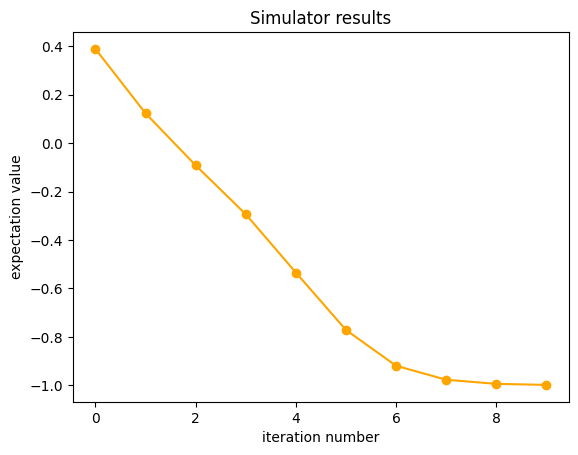

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(job.metrics())
df.sort_values(by=["iteration_number"], inplace=True)

plt.plot(df["iteration_number"], df["expval"], "-o", color="orange")
plt.xlabel("iteration number")
plt.ylabel("expectation value")
plt.title("Simulator results")

plt.show()

## Running on a QPU with priority

The next step is to see how well the qubit rotation works on a real QPU. We
create a hybrid job with a priority QPU. We also increase the number of
steps to 10.

Using hybrid jobs for iterative algorithms is very beneficial because you retain priority access to the
target QPU. So once your quantum tasks are created in the hybrid job, they run ahead of other tasks
waiting in the *quantum task queue*. This means your
algorithm will not be interrupted by other quantum tasks, so it will run more efficiently and
predictably. Quantum tasks submitted as part of a hybrid job have priority, and are aggregated in the *priority task queue*.

Hybrid jobs have their own *hybrid jobs queue* so that only a single
hybrid job can run on a QPU at a time. Each QPU has its own hybrid jobs queue. Note that this is a different queue from the quantum tasks. For a single quantum circuit, or a batch of circuit, it’s
recommended to create quantum tasks instead of hybrid jobs. For more information on quantum tasks and hybrid jobs queue see the [Amazon Braket documentation](https://docs.aws.amazon.com/braket/latest/developerguide/braket-task-when.html).

To get QPU priority, you must ensure that the device ARN used within the function matches that
specified in the decorator. For convenience, you can use the helper function ``get_device_arn()`` to
automatically capture the device ARN declared in ``@hybrid_job``.

<div class="alert alert-block alert-info">
    <b>Note:</b> Only hybrid jobs running on AWS receive priority. Hybrid jobs running <a href="https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-local-mode.html">locally</a>, or with a mismatched device ARN do not get priority task queueing. 
</div>

In the previous example, we declared the local simulator outside the decorated function scope.
However, for AWS devices such as QPUs or on-demand simulators, the device must be declared within the function scope. 

<div class="alert alert-block alert-info">
    <b>Note:</b> AWS devices must be declared within the body of the decorated function.
</div>

In [ ]:
from braket.devices import Devices

device_arn = Devices.Amazon.SV1
# device_arn = Devices.Rigetti.Ankaa3  # <-- uncomment this line to actually use Ankaa-3, it will cost about 120 USD


@hybrid_job(device=device_arn)  # set priority QPU
def qpu_qubit_rotation_hybrid_job(num_steps=10, stepsize=0.5):
    # AWS devices must be declared within the decorated function.
    device = qml.device(
        "braket.aws.qubit",
        device_arn=device_arn.value,  # Make sure the device ARN matches the hybrid job device ARN
        wires=2,
        shots=1_000,
    )

    @qml.qnode(device)
    def circuit(params):
        qml.RX(params[0], wires=0)
        qml.RY(params[1], wires=0)
        return qml.expval(qml.PauliZ(0))

    opt = qml.GradientDescentOptimizer(stepsize=stepsize)
    params = np.array([0.5, 0.75])

    for i in range(num_steps):
        # update the circuit parameters
        params = opt.step(circuit, params)
        expval = circuit(params)

        log_metric(metric_name="expval", iteration_number=i, value=expval)

    return params

To get a sense of how long we will wait before the hybrid job runs, we can check the hybrid job
queue depth with `AwsDevice(device_arn).queue_depth().jobs`. We can also check if the device is
currently available with `AwsDevice(device_arn).is_available()`.

You can check the queue depth on the devices page of the [Amazon Braket Console](https://console.aws.amazon.com/braket/home). Below, we show the devices page for IQM Garnet.

![IQM Garnet showing the queue depths.](console_figures/queue_viz_ankaa3.png)



When there are no other hybrid jobs in the queue ahead of you, and the device is available, the hybrid job will start running.

<div class="alert alert-block alert-info">
    <b>Note:</b> Running the following cell will only run once the QPU is available. This may take a long time and will result in usage fees charged to your AWS account. Only run the cell if you are comfortable with the potential wait-time and costs. We recommend monitoring the Billing & Cost Management Dashboard on the AWS console.
</div>

In [13]:
qpu_job = qpu_qubit_rotation_hybrid_job(num_steps=10, stepsize=0.5)
print(qpu_job)

AwsQuantumJob('arn':'arn:aws:braket:us-west-1:606892779558:job/762286ee-aaf8-40ab-adf4-ef094be48b31')


Next, we wait for the algorithm to complete and download the result. 

In [15]:
qpu_job.result()

{'result': tensor([0.078 , 3.0705], requires_grad=True)}

Next, we plot the expectation value per iteration number below. We see that on a real QPU, the data is not as smooth as the simulator, but the minimum still is detected correctly!

In [16]:
# May need to wait a bit before metrics show up
# If metrics aren't there, try again after 5 seconds
import time

time.sleep(10)
print(qpu_job.metrics())

{'timestamp': [1739913746.459814, 1739913731.6831815, 1739913721.443697, 1739913709.235564, 1739913696.7142353, 1739913683.6655934, 1739913669.0350077, 1739913656.018912, 1739913639.4800808, 1739913626.318294], 'expval': [-0.764, -0.832, -0.714, -0.664, -0.522, -0.324, -0.1, -0.018, 0.178, 0.388], 'iteration_number': [9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0]}


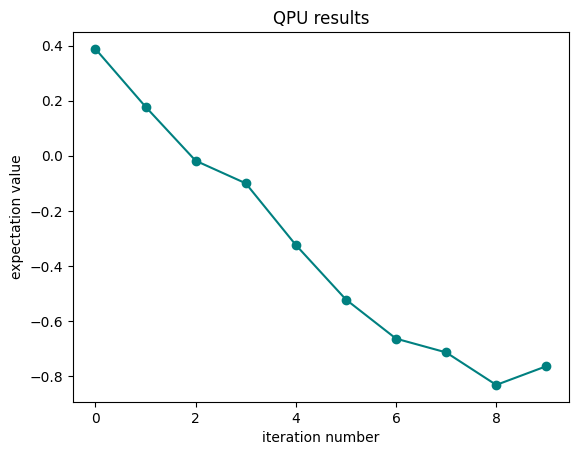

In [17]:
df = pd.DataFrame(qpu_job.metrics())
df.sort_values(by=["iteration_number"], inplace=True)

plt.plot(df["iteration_number"], df["expval"], "-o", color="teal")
plt.xlabel("iteration number")
plt.ylabel("expectation value")
plt.title("QPU results")
plt.show()

<div class="alert alert-block alert-info">
    <b>Note:</b> Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. 
    Estimated charges shown may differ from your actual charges. 
    Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)
    Estimated cost to run this example is $55 USD.
</div>

In [ ]:
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)."
)
print(
    f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD"
)

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 72.011 USD


## Conclusion

In this tutorial, we showed how to migrate from local Python functions to running algorithms on simulators and QPUs on Amazon Braket.
We adapted the simple example of rotating a qubit using gradient descent, running this on both a
local simulator and a real QPU. 
Using Amazon Braket Hybrid Jobs allowed us to run algorithms asynchronously, scale classical compute using AWS, and obtain priority access to the selected QPU for the duration of our algorithm.